## Name : Omar Hamdy Abdelazim
## Task : Sales_Forecasting_Description

## 1- Imports

In [22]:
# --- Imports ---
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

## 2- Load Data & Quick Peek

In [23]:
# --- Load CSV files & quick peek ---
train_df = pd.read_csv('train.csv')
test_df  = pd.read_csv('test.csv')

# Show the training dataframe
train_df

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False
...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False
421566,45,98,2012-10-05,628.10,False
421567,45,98,2012-10-12,1061.02,False
421568,45,98,2012-10-19,760.01,False


## 3 Basic Info

In [24]:
# --- Inspect training data info ---
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


## 4- Parse Dates & Sort

In [25]:
# --- Parse dates and sort by time ---
train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date']  = pd.to_datetime(test_df['Date'])

# Sort ascending by date (important for lag features)
train_df = train_df.sort_values('Date')

## 5- Lag Features (1–4) & 4-Week Rolling Mean

In [26]:
# --- Create lag features and rolling mean ---
# Group by Store/Dept once and reuse
group_sales = train_df.groupby(['Store', 'Dept'])['Weekly_Sales']

# Lags: previous 1..4 weeks
for k in range(1, 5):
    train_df[f'Lag_{k}'] = group_sales.shift(k)

# Rolling mean over the last 4 weeks (min_periods=1 to match original behavior)
train_df['Rolling_Avg_4'] = group_sales.transform(
    lambda s: s.rolling(window=4, min_periods=1).mean()
)

## 6- Calendar Features

In [27]:
# --- Calendar-derived features ---
train_df['Year']  = train_df['Date'].dt.year
train_df['Month'] = train_df['Date'].dt.month
train_df['Day']   = train_df['Date'].dt.day
train_df['Week']  = train_df['Date'].dt.isocalendar().week  # same as original

test_df['Year']  = test_df['Date'].dt.year
test_df['Month'] = test_df['Date'].dt.month
test_df['Day']   = test_df['Date'].dt.day
test_df['Week']  = test_df['Date'].dt.isocalendar().week

## 7- Missing Values Check & Fill

In [28]:
# --- Check for missing values then fill ---
train_df.isnull().sum()

# Fill NaNs with 0 as done originally
train_df = train_df.fillna(0)

## 8- Train/Validation Split & Feature Matrix

In [29]:
# --- Split into train/validation and build feature matrices ---
split_idx  = int(len(train_df) * 0.8)
train_part = train_df.iloc[:split_idx]
val_part   = train_df.iloc[split_idx:]

FEATURES = [
    'Store', 'Dept', 'Year', 'Month', 'Week', 'Day', 'IsHoliday',
    'Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Rolling_Avg_4'
]
TARGET = 'Weekly_Sales'

X_train = train_part[FEATURES].copy()
y_train = train_part[TARGET].copy()

X_val   = val_part[FEATURES].copy()
y_val   = val_part[TARGET].copy()


## 9- Linear Regression: Train, Evaluate, Plot

Linear Regression Mean Absolute Error on validation set: 1146.6557517304057


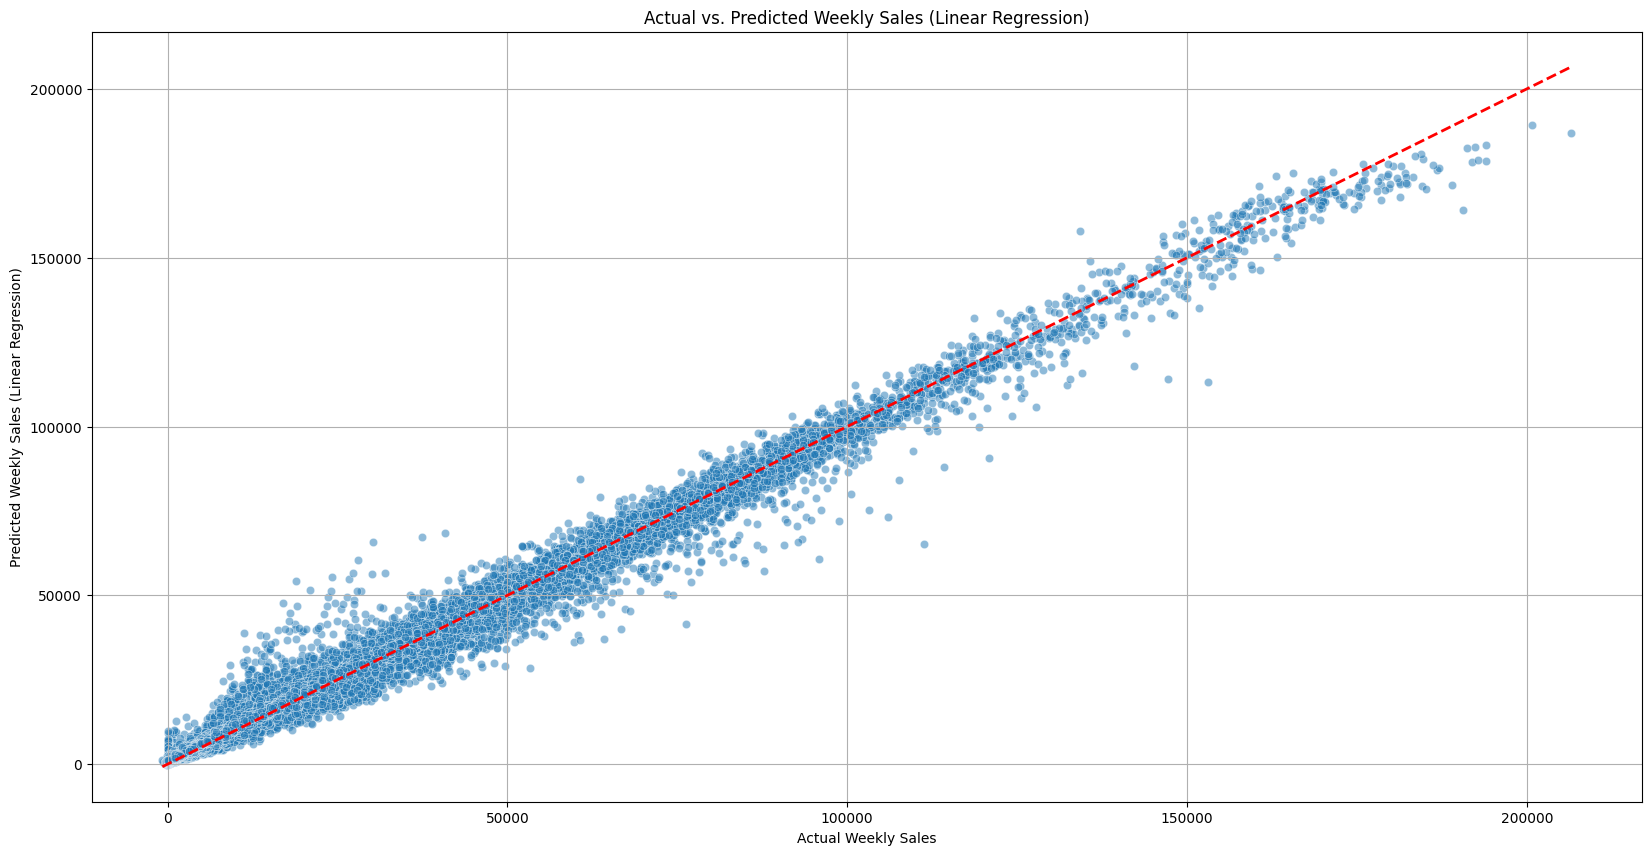

In [30]:
# --- Linear Regression training & evaluation ---
lr = LinearRegression()
lr.fit(X_train, y_train)

pred_val_lr = lr.predict(X_val)
mae_lr = mean_absolute_error(y_val, pred_val_lr)
print(f'Linear Regression Mean Absolute Error on validation set: {mae_lr}')

# --- Plot: Actual vs Predicted (LR) ---
plt.figure(figsize=(20, 10))
sns.scatterplot(x=y_val, y=pred_val_lr, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', linewidth=2)
plt.xlabel('Actual Weekly Sales')
plt.ylabel('Predicted Weekly Sales (Linear Regression)')
plt.title('Actual vs. Predicted Weekly Sales (Linear Regression)')
plt.grid(True)
plt.show()

## 10- XGBoost: Train, Evaluate, Plot

XGBoost Mean Absolute Error on validation set: 1002.9297832718992


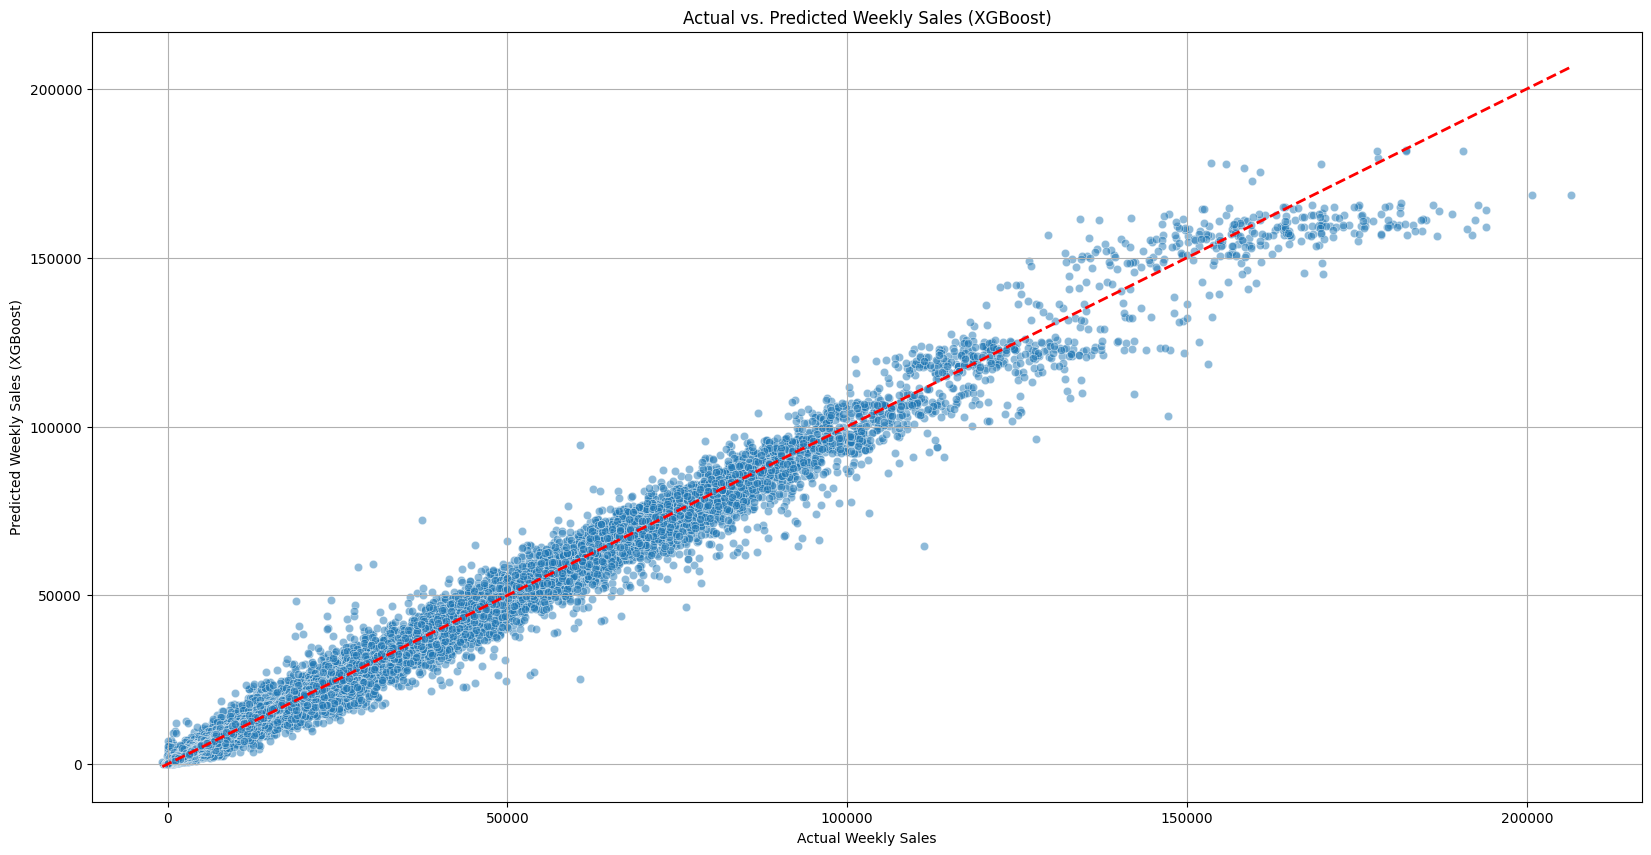

In [31]:
# --- XGBoost training & evaluation ---
# Ensure IsHoliday is integer for the model, same as original logic
X_train['IsHoliday'] = X_train['IsHoliday'].astype(int)
X_val['IsHoliday']   = X_val['IsHoliday'].astype(int)

xgb_reg = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
xgb_reg.fit(X_train, y_train)

pred_val_xgb = xgb_reg.predict(X_val)
mae_xgb = mean_absolute_error(y_val, pred_val_xgb)
print(f'XGBoost Mean Absolute Error on validation set: {mae_xgb}')

# --- Plot: Actual vs Predicted (XGBoost) ---
plt.figure(figsize=(20, 10))
sns.scatterplot(x=y_val, y=pred_val_xgb, alpha=0.5)
plt.plot([y_val.min()], [y_val.min()], alpha=0)  # keep axes stable if needed
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', linewidth=2)
plt.xlabel('Actual Weekly Sales')
plt.ylabel('Predicted Weekly Sales (XGBoost)')
plt.title('Actual vs. Predicted Weekly Sales (XGBoost)')
plt.grid(True)
plt.show()